In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [54]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (256,256)
BATCH_SIZE = 32

train_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
test_dir = "../input/new-plant-diseases-dataset/test"

train_datagen = ImageDataGenerator(rescale = 1/255.)
valid_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')
print("Validating Images:")
valid_data = train_datagen.flow_from_directory(valid_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')
print("Test Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'categorical')

Training Images:
Found 70295 images belonging to 38 classes.
Validating Images:
Found 17572 images belonging to 38 classes.
Test Images:
Found 33 images belonging to 1 classes.


In [8]:
efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'


In [79]:
import itertools
import matplotlib.pyplot as plt
import numpy as np

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
def create_model(model_url,num_classes):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = 'feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE+(3,))
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes,"softmax",name="output_layer")
    ])
    return model

In [11]:
efficientNet_model = create_model(efficientnet_url,train_data.num_classes)

2022-10-14 18:34:07.776725: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-14 18:34:07.779937: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-14 18:34:07.830367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 18:34:07.831100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-10-14 18:34:07.831158: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-14 18:34:07.877462: I tensorflow/stream_executor/platform/def

In [12]:
efficientNet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 38)                48678     
Total params: 4,098,242
Trainable params: 48,678
Non-trainable params: 4,049,564
_________________________________________________________________


In [13]:
efficientNet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy']
                     )

In [14]:
efficientNet_history = efficientNet_model.fit(train_data,
                       epochs = 5,
                       steps_per_epoch = len(train_data),
                       validation_data = valid_data,
                       validation_steps= len(valid_data),
                      )

Epoch 1/5


2022-10-14 18:34:26.153296: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-14 18:34:27.171445: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-10-14 18:34:27.195650: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


2197/2197 [==============================] - 807s 363ms/step - loss: 0.7421 - accuracy: 0.8518 - val_loss: 0.1265 - val_accuracy: 0.9688
Epoch 2/5
2197/2197 [==============================] - 282s 128ms/step - loss: 0.1016 - accuracy: 0.9761 - val_loss: 0.0847 - val_accuracy: 0.9756
Epoch 3/5
2197/2197 [==============================] - 292s 133ms/step - loss: 0.0600 - accuracy: 0.9858 - val_loss: 0.0631 - val_accuracy: 0.9829
Epoch 4/5
2197/2197 [==============================] - 286s 130ms/step - loss: 0.0418 - accuracy: 0.9902 - val_loss: 0.0547 - val_accuracy: 0.9849
Epoch 5/5
2197/2197 [==============================] - 286s 130ms/step - loss: 0.0325 - accuracy: 0.9932 - val_loss: 0.0476 - val_accuracy: 0.9863


In [55]:
import numpy as np
prediction = np.argmax(efficientNet_model.predict(test_data),axis=1)
prediction

array([29,  0, 20, 37, 20,  0, 22, 35, 35,  8, 35,  2,  2, 29, 37, 37, 20,
        2, 20, 35,  8, 30, 29, 20, 35,  2,  8, 37, 29,  0, 29, 22, 35])

In [35]:
efficientNet_model.save('./model')

In [20]:
import os

In [78]:
model = tf.keras.models.load_model('./model')

In [81]:
def load_and_prep_image(filename, img_shape=256, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

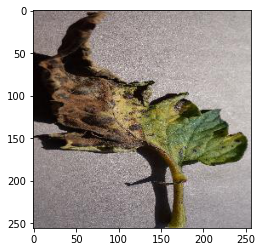

(1, 38)
Cherry_(including_sour)___healthy


In [23]:
import matplotlib.pyplot as plt
x, y = next(test_data)
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()
    image = image.reshape(1, 256, 256, 3)
    pred_vec = efficientNet_model.predict(image)
    print(pred_vec.shape)
    pred_max = np.argmax(pred_vec,axis=1)
    print(diseases[int(pred_max)])

In [70]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20,20),text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  

In [68]:
Y_pred = efficientNet_model.predict(valid_data, num_of_test_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_data.classes, y_pred))
print('Classification Report')
target_names = diseases
print(classification_report(valid_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[17 15 15 ... 10 12 13]
 [14 16  9 ... 11 19 17]
 [13 11  6 ... 14  3 15]
 ...
 [18 12 17 ...  9 13 14]
 [19 13 12 ... 15  9 10]
 [12 19  4 ... 17  9 10]]
Classification Report


NameError: name 'classification_report' is not defined

In [62]:
num_of_test_samples = 17572

In [63]:
diseases = os.listdir(train_dir)
diseases

['Tomato___Late_blight',
 'Tomato___healthy',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Potato___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Early_blight',
 'Tomato___Septoria_leaf_spot',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Strawberry___Leaf_scorch',
 'Peach___healthy',
 'Apple___Apple_scab',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Apple___Black_rot',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Peach___Bacterial_spot',
 'Apple___Cedar_apple_rust',
 'Tomato___Target_Spot',
 'Pepper,_bell___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Potato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Strawberry___healthy',
 'Apple___healthy',
 'Grape___Black_rot',
 'Potato___Early_blight',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Common_rust_',
 'Grape___Esca_(Black_Measles)',
 'Raspberry___healthy'

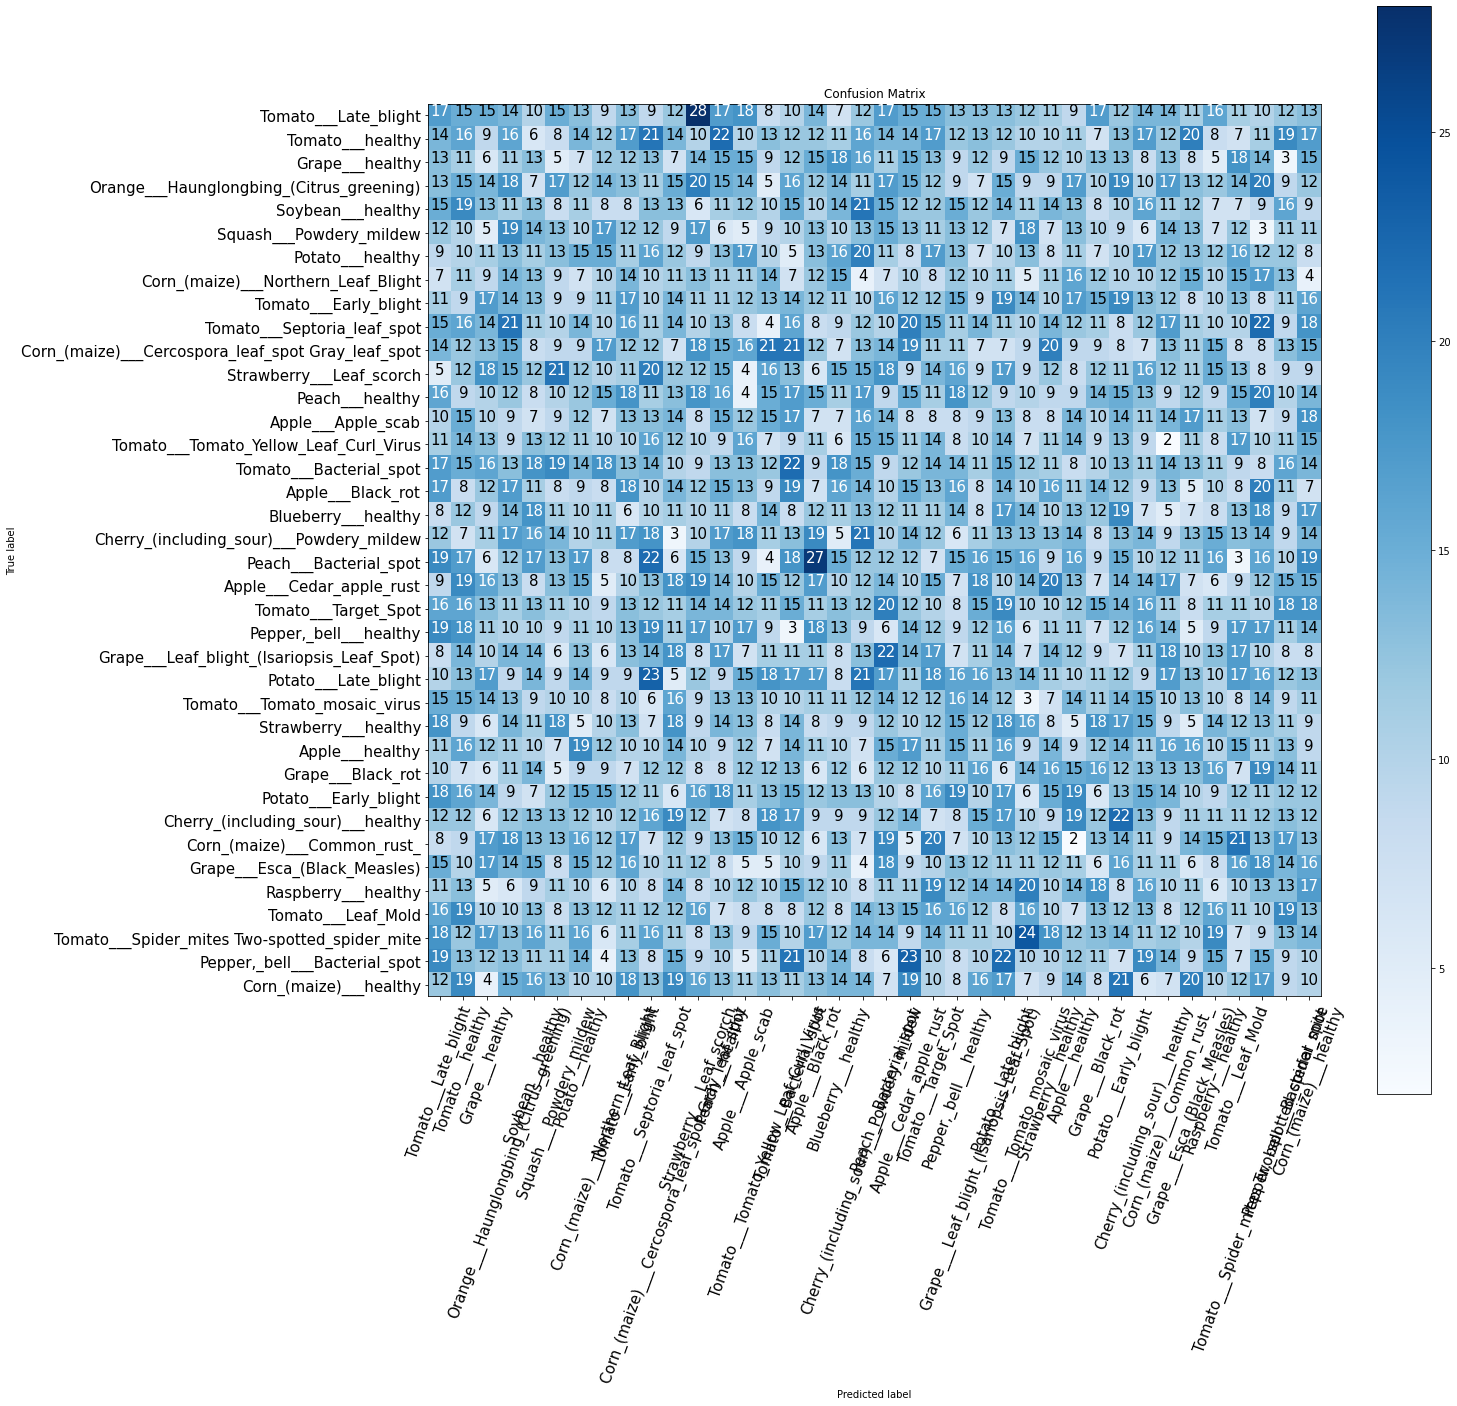

In [80]:
make_confusion_matrix(valid_data.classes, y_pred,classes=diseases)

In [76]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

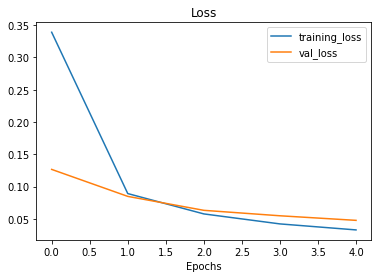

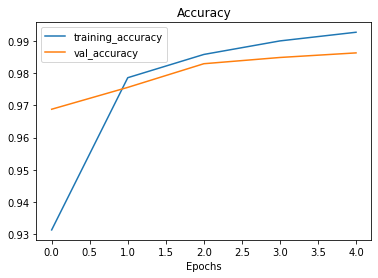

In [77]:
plot_loss_curves(efficientNet_history)